In [1]:
import wandb
wandb.init(project='ddpm_3D_inpaint',name='test_unit')
import wandb


# Standard libraries
import os
import tempfile
import time
import io
import random
import math
import warnings
from multiprocessing import Manager
from typing import Optional
from monai.networks.blocks import Convolution
# Data manipulation libraries
import numpy as np
import pandas as pd
import scipy

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset, random_split

# MONAI libraries
# from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism

# Other medical image processing libraries
import SimpleITK as sitk
import torchio as tio

# Plotting and visualization
import matplotlib.pyplot as plt

# Progress bar
from tqdm import tqdm

# Custom modules
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler

# Weights and Biases for experiment tracking
from dataloader import Train,Eval


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hale-akrami (usc_akrami). Use `wandb login --relogin` to force relogin


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [9]:
def generate_random_block_checkerboard_mask(batch_size, image_shape):
    """
    Generate a random checkerboard mask for a batch of 3D images with varying block sizes.

    :param batch_size: Number of images in the batch.
    :param image_shape: Shape of the 3D images (depth, height, width).
    :return: Batch of checkerboard masks.
    """
    # Possible block sizes
    possible_block_sizes = [(8, 8, 8)]

    # Randomly select a block size
    block_size = random.choice(possible_block_sizes)

    # Calculate the number of blocks along each dimension
    num_blocks = [dim // block for dim, block in zip(image_shape, block_size)]

    # Create a random tensor of the size of the number of blocks
    random_blocks = torch.randint(0, 2, (batch_size, *num_blocks))

    # Repeat the blocks to match the original image size
    repeated_blocks = random_blocks.repeat_interleave(block_size[0], dim=1)\
                                   .repeat_interleave(block_size[1], dim=2)\
                                   .repeat_interleave(block_size[2], dim=3)

    # Crop the repeated blocks to match the exact image shape
    masks = repeated_blocks[:, :image_shape[0], :image_shape[1], :image_shape[2]]

    return masks,block_size

In [3]:
# Generate masks with randomly chosen block sizes


config = {
    'batch_size': 1,
    'imgDimResize':(160,192,160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True, 
    'perc_low': 0, 
    'perc_high': 100,
    'rescaleFactor':2,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}

# %%
wandb.config.update(config )


imgpath = {}
# '/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv'
#'/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/IXI_train_fold0.csv',
#csvpath_trains = ['/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv', '/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv']
csvpath_trains=['./Data/splits/combined_4datasets.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = './Data/splits/IXI_test.csv'
csvpath_test = './Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)
# %%


var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] = ''
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state != 'test':
        var_csv[state]['seg_path'] = None
    else:
        var_csv[state]['seg_path'] = pathBase  + var_csv[state]['seg_path']

    # if cfg.mode == 't2': 
    #     var_csv[state] =var_csv[state][var_csv[state].img_name.isin(keep_t2['0'].str.replace('t2','t1'))]
    #     var_csv[state]['img_path'] = var_csv[state]['img_path'].str.replace('t1','t2')
    
    
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)



#data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=16)

In [5]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 64],
    attention_levels=[False, False,True],
    num_head_channels=[0, 0,32],
    num_res_blocks=2,
)
#model_filename = '/acmenas/hakrami/3D_lesion_DF/models/halfres/model_epoch984.pt'
#model_filename = '/acmenas/hakrami/3D_lesion_DF/models/norm2/model_epoch624.pt'
model_filename ='/scratch1/akrami/storage/DF_results/models/model_large_epoch999.pt'

model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.load_state_dict(torch.load(model_filename)) 
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)



original_conv1 = model.module.conv_in
new_conv1 = Convolution(
            spatial_dims=3,
            in_channels=3,
            out_channels=original_conv1.out_channels,
            strides=1,
            kernel_size=3,
            padding=1,
            conv_only=True,
        )

# # Create a new conv layer with 3 input channels and the same output channels, kernel size, etc.
# new_conv1 = nn.Conv2d(3, original_conv1.out_channels, kernel_size=original_conv1.kernel_size, 
#                       stride=original_conv1.stride, padding=original_conv1.padding)

# Copy the weights from the original channel
with torch.no_grad():
    new_conv1.conv.weight[:, :1, :, :,:] = original_conv1.conv.weight.clone()  # Copy weights for the original channel
    # Initialize the weights for the new channels to zero
    new_conv1.conv.weight[:, 1:, :, :,:].zero_()  # Zero out weights for the additional channels
    new_conv1.conv.bias = torch.nn.Parameter(original_conv1.conv.bias.clone())


# Replace the original conv1 layer with the new one
model.module.conv_in = new_conv1
model = model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

Using 2 GPUs!


In [55]:
model_filename ='/project/ajoshi_27/akrami/3D_lesion_DF/models/model_inpaint_epoch925.pt'
model.load_state_dict(torch.load(model_filename)) 

<All keys matched successfully>

In [56]:
sub_test = next(iter(val_loader))
print(sub_test.keys())
print(sub_test['age'])
# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
image_array[image_array<0.01]=0
peak_expanded = peak_expanded.to(device)
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2

dict_keys(['vol', 'peak', 'age', 'ID', 'path', 'mask'])
tensor([35.0700], dtype=torch.float64)


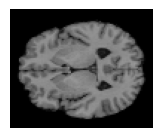

In [57]:
plt.figure(figsize=(2, 2))
plt.imshow(image_array[0, 0, :, :, middle_slice_idx].cpu(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

100%|██████████| 1000/1000 [02:42<00:00,  6.17it/s]


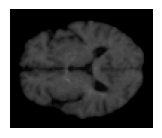

In [58]:
image = torch.randn_like(image_array)[0:1,:,:,:]
image = image.to(device)
current_img = torch.randn_like(image).to(device)

masks_random_blocks = image*0
maked_input = image*masks_random_blocks
combined_tensor = torch.cat((current_img,masks_random_blocks), dim=1)
combined_tensor = torch.cat((combined_tensor, maked_input), dim=1)
scheduler.set_timesteps(num_inference_steps=1000)
progress_bar = tqdm(scheduler.timesteps)
for t in progress_bar:  # go through the noising process
    with autocast(enabled=False):
        with torch.no_grad():
            model_output = model(combined_tensor, timesteps=torch.Tensor((t,)).to(image.device))
            current_img, _ = scheduler.step(
                model_output, t, current_img
            )  # this is the prediction x_t at the time step t
        
            combined_tensor = torch.cat((current_img,masks_random_blocks), dim=1)
            combined_tensor = torch.cat((combined_tensor, maked_input), dim=1)
            

middle_slice_idx = image.size(-1) // 2
plt.figure(figsize=(2, 2))
plt.imshow(current_img[0, 0, :, :, middle_slice_idx].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()


In [59]:
batch_size = image_array.shape[0]
image_shape = image_array.shape[2:]
masks_random_blocks,_ = generate_random_block_checkerboard_mask(batch_size, image_shape)

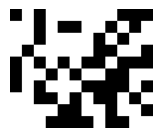

In [60]:
plt.figure(figsize=(2, 2))
plt.imshow(mask[0, :, :, middle_slice_idx], vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [61]:
masks_random_blocks=masks_random_blocks.unsqueeze(dim=1).to(device)

In [62]:

image = image_array[0:1,:,:,:]
image = image.to(device)
current_img = torch.randn_like(image).to(device)
print(current_img.shape)


torch.Size([1, 1, 80, 96, 80])


In [63]:


maked_input = image*masks_random_blocks
combined_tensor = torch.cat((current_img,masks_random_blocks), dim=1)
combined_tensor = torch.cat((combined_tensor, maked_input), dim=1)
scheduler.set_timesteps(num_inference_steps=1000)
progress_bar = tqdm(scheduler.timesteps)
for t in progress_bar:  # go through the noising process
    with autocast(enabled=False):
        with torch.no_grad():
            model_output = model(combined_tensor, timesteps=torch.Tensor((t,)).to(image.device))
            current_img, _ = scheduler.step(
                model_output, t, current_img
            )  # this is the prediction x_t at the time step t
        
            combined_tensor = torch.cat((current_img,masks_random_blocks), dim=1)
            combined_tensor = torch.cat((combined_tensor, maked_input), dim=1)
            




100%|██████████| 1000/1000 [02:42<00:00,  6.14it/s]


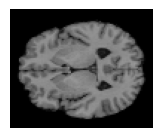

In [64]:
middle_slice_idx = image.size(-1) // 2
plt.figure(figsize=(2, 2))
plt.imshow(image[0, 0, :, :, middle_slice_idx].cpu(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

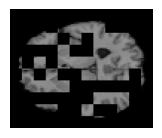

In [65]:
middle_slice_idx = image.size(-1) // 2
plt.figure(figsize=(2, 2))
plt.imshow(maked_input[0, 0, :, :, middle_slice_idx].cpu(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

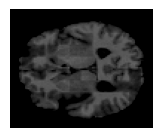

In [66]:
middle_slice_idx = image.size(-1) // 2
plt.figure(figsize=(2, 2))
plt.imshow(current_img[0, 0, :, :, middle_slice_idx].cpu(), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [ ]:
sub_test = next(iter(test_loader))
print(sub_test.keys())
print(sub_test['age'])
# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
image_array[image_array<0.01]=0
peak_expanded = peak_expanded.to(device)
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2